In [12]:
import requests
import chess
import chess.engine
import time
import joblib
from dataclasses import dataclass, field
from typing import Optional, List
import queue
import re
import heapq

In [3]:
path = "C:/Users/calal/Downloads/lc0-v0.30.0-windows-gpu-nvidia-cuda/"
lc0_path = f"{path}lc0.exe"

In [4]:
board_evals = {}
candidate_cache = {}

In [18]:
def get_candidate_moves(fen, threshold, speeds=["blitz", "rapid", "classical"], ratings=[0,4000]):
    """
    Queries the Lichess opening explorer for candidate moves given a FEN string.
    Raises an exception if the request fails repeatedly.
    """
    if fen in candidate_cache.keys():
        return candidate_cache[fen]

    url = "https://explorer.lichess.ovh/lichess"
    params = {
        "fen": fen,
        "speeds[]": speeds,
        "ratings[]": ratings,
        "topGames": 0,
        "recentGames": 0,
        "moves": 10,
    }

    max_retries = 3
    last_exception = None
    for attempt in range(max_retries):
        try:
            time.sleep(0.5)  # Sleep for 500ms before making the request
            response = requests.get(url, params=params)
            response.raise_for_status()  # Check for HTTP errors
            data = response.json()

            moves = {}
            for move in data.get('moves', []):
                uci_move = move['uci']
                frequency = move['white'] + move['draws'] + move['black']
                moves[uci_move] = frequency

            total = sum(moves.values())
            for move in list(moves):
                moves[move] /= total
                if moves[move] < threshold or move == 'a1a1':
                    del moves[move]

            total = sum(moves.values())
            for move in list(moves):
                moves[move] /= total

            candidate_cache[fen] = moves
            return moves  # Return immediately after a successful response

        except requests.exceptions.RequestException as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            last_exception = e
            time.sleep(61*(attempt+1)*(attempt+1))  # Wait for 1-9 minutes before retrying

    print("Maximum retries reached. Failing loudly.")
    raise last_exception  # Raise the last caught exception


def extract_v_value(string):
    match = re.search(r'\(V:\s*([-\d.]+)\)', string)
    if match:
        return float(match.group(1))
    else:
        return None

def evaluate_position(engine, board):
    # Use LC0 to evaluate the position
    fen = board.fen()
    if fen in board_evals.keys():
        return board_evals[fen]
    else:
        string = engine.analyse(board, chess.engine.Limit(nodes=1))['string']
        eval = extract_v_value(string)
        board_evals[fen] = eval
    return eval

def calculate_expected_value(response_candidates, evaluation):
    ev = 0
    for response in response_candidates.keys():
        ev += response_candidates[response] * evaluation[response]
    
    return ev

def recursive_evaluation(engine, board, frequency=1, ev=0, threshold=0.08):
    fen = board.fen()
    candidates = get_candidate_moves(fen, 0.02)
    move_expected_values = {}
    move_expected_values[None] = ev

    #print(fen, frequency, ev)

    # Evaluate each candidate move
    for move in candidates:
        try:
            # Attempt to push the move onto the board
            board.push_uci(move)
        except chess.InvalidMoveError:
            print(f"Illegal move {move} encountered in {fen}. Skipping this node.")
            continue

        response_candidates = get_candidate_moves(board.fen(), 0.02)

        move_expected_values[move] = 0
        for response, response_freq in response_candidates.items():
            try:
                # Attempt to push the move onto the board
                board.push_uci(response)
            except chess.InvalidMoveError:
                print(f"Illegal move {response} encountered in {fen}. Skipping this node.")
                continue
            naive_eval = evaluate_position(engine, board)
            if naive_eval + 0.3 < max(move_expected_values.values()) or frequency*response_freq < threshold:
                move_expected_values[move] += naive_eval * response_freq
                #print(fen, move, response, frequency * response_freq, naive_eval)
            else:
                _, evaluation = recursive_evaluation(engine, board, frequency * response_freq, max(move_expected_values.values()))
                move_expected_values[move] += evaluation * response_freq
                #print(fen, move, response, frequency * response_freq, evaluation)
            board.pop()

        board.pop()
    
    # Find the move with the maximum expected value
    move_expected_values[None] = -1
    best_move = max(move_expected_values, key=move_expected_values.get)
    return best_move, move_expected_values[best_move]

In [19]:
@dataclass
class MoveNode:
    fen: str  # FEN string of the position after the prev_move
    prev_move: Optional[str] = None  # UCI format move that led to this FEN
    move: Optional[str] = None  # The best move from this position
    evaluation: Optional[float] = None  # Evaluation of the position after the move
    probability: float = 1.0  # Probability of reaching this position
    parent: Optional['MoveNode'] = None
    children: List['MoveNode'] = field(default_factory=list)

    def add_child(self, prev_move, fen, move, evaluation, probability):
        new_child = MoveNode(
            fen=fen,
            prev_move=prev_move,
            move=move,
            evaluation=evaluation,
            probability=probability,
            parent=self
        )
        self.children.append(new_child)
        return new_child

In [14]:
engine = chess.engine.SimpleEngine.popen_uci(lc0_path)
engine.configure({"VerboseMoveStats": "true"})
board = chess.Board()
threshold = 0.01
board_evals = joblib.load('board_evals.dat')
candidate_cache = joblib.load('candidate_cache.dat')
root_node = joblib.load('tree.dat')
pq = []

# Evaluate the best move for the initial position
#best_move, evaluation = recursive_evaluation(engine, board)
board.push_uci(root_node.move)

# Set up the priority queue and process responses to the best move
response_candidates = get_candidate_moves(board.fen(), 0.02)
for response_move, response_prob in response_candidates.items():
    if response_prob >= threshold:
        board.push_uci(response_move)
        fen_after_response = board.fen()
        board.pop()

        # Construct child node using keyword arguments
        child_node = root_node.add_child(
            fen=fen_after_response,
            prev_move=response_move,
            move=None,
            evaluation=None,
            probability=response_prob
        )
        heapq.heappush(pq, (-response_prob, child_node))

<UciProtocol (pid=20684)>: stderr >>        _
<UciProtocol (pid=20684)>: stderr >> |   _ | |
<UciProtocol (pid=20684)>: stderr >> |_ |_ |_| v0.30.0 built Jul 21 2023
<UciProtocol (pid=20684)>: stderr >> Found configuration file: C:\Users\calal\Downloads\lc0-v0.30.0-windows-gpu-nvidia-cuda/lc0.config


In [20]:
engine = chess.engine.SimpleEngine.popen_uci(lc0_path)
engine.configure({"VerboseMoveStats": "true"})
board = chess.Board()
threshold = 0.01
board_evals = joblib.load('board_evals.dat')
candidate_cache = joblib.load('candidate_cache.dat')
root_node = joblib.load('tree.dat')
pq = joblib.load('pq.dat')

# Evaluate the best move for the initial position
#best_move, evaluation = recursive_evaluation(engine, board)
best_move = 'e2e4'
evaluation = 0.3
board.push_uci(best_move)
root_node.move = best_move
root_node.evaluation = evaluation

while pq:
    _, current_node = heapq.heappop(pq)
    print(current_node.fen)
    board = chess.Board(current_node.fen)
    best_move, evaluation = recursive_evaluation(engine, board)
    try:
        board.push_uci(best_move)
    except chess.InvalidMoveError:
        print(f"Illegal move {best_move} encountered in {current_node.fen}. Skipping this node.")
        continue
    current_node.move = best_move
    current_node.evaluation = evaluation

    next_move_candidates = get_candidate_moves(board.fen(), 0.02)
    for next_move, next_move_prob in next_move_candidates.items():
        new_probability = current_node.probability * next_move_prob
        if new_probability >= threshold:
            board.push_uci(next_move)
            fen_after_move = board.fen()
            board.pop()

            # Add child node for the next move
            child_node = current_node.add_child(
                prev_move=next_move,
                fen=fen_after_move,
                move=None,
                evaluation=None,
                probability=new_probability
            )
            heapq.heappush(pq, (-response_prob, child_node))
    joblib.dump(board_evals, "board_evals.dat")
    joblib.dump(candidate_cache, "candidate_cache.dat")
    joblib.dump(root_node, 'tree.dat')
    joblib.dump(pq, 'pq.dat')

<UciProtocol (pid=336)>: stderr >>        _
<UciProtocol (pid=336)>: stderr >> |   _ | |
<UciProtocol (pid=336)>: stderr >> |_ |_ |_| v0.30.0 built Jul 21 2023
<UciProtocol (pid=336)>: stderr >> Found configuration file: C:\Users\calal\Downloads\lc0-v0.30.0-windows-gpu-nvidia-cuda/lc0.config


TypeError: '<' not supported between instances of 'MoveNode' and 'MoveNode'

In [13]:
print(root_node.move)
for child in root_node.children:
    if child.move:
        print(child.prev_move, child.move)
    for grandchild in child.children:
        if grandchild.move:
            print(' '*4, grandchild.prev_move, grandchild.move)
        for ggchild in grandchild.children:
            if ggchild.move:
                print(' '*9, ggchild.prev_move, ggchild.move)
            for gggchild in ggchild.children:
                if gggchild.move:
                    print(' '*14, gggchild.prev_move, gggchild.move)
                for ggggchild in gggchild.children:
                    if ggggchild.move:
                        print(' '*19, ggggchild.prev_move, ggggchild.move)

e2e4
e7e5 g1f3
     b8c6 f1c4
          g8f6 f3g5
          f8c5 c2c3
c7c5 d2d4
     c5d4 g1f3
          b8c6 f3d4
d7d5 e4d5
     d8d5 b1c3
e7e6 d2d4


In [1]:
while not q.empty():
    joblib.dump(root_node, 'tree.dat')
    _, current_node = q.get()
    board = chess.Board(current_node.fen)
    best_move, evaluation = recursive_evaluation(engine, board)
    try:
        board.push_uci(best_move)
    except chess.InvalidMoveError:
        print(f"Illegal move {best_move} encountered in {current_node.fen}. Skipping this node.")
        continue
    current_node.move = best_move
    current_node.evaluation = evaluation

    next_move_candidates = get_candidate_moves(board.fen(), 0.02)
    for next_move, next_move_prob in next_move_candidates.items():
        new_probability = current_node.probability * next_move_prob
        if new_probability >= threshold:
            board.push_uci(next_move)
            fen_after_move = board.fen()
            board.pop()

            # Add child node for the next move
            child_node = current_node.add_child(
                prev_move=next_move,
                fen=fen_after_move,
                move=None,
                evaluation=None,
                probability=new_probability
            )
            q.put((-new_probability, child_node))

NameError: name 'q' is not defined

In [53]:
board = chess.Board()
board.push_uci(best_move)

Move.from_uci('e2e4')

In [63]:
root_node.children[2].children

[MoveNode(fen='r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 3', prev_move='g1f3', move='f1c4', evaluation=0.3614834224971196, probability=0.25778640990944035, parent=MoveNode(fen='rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2', prev_move='e7e5', move='g1f3', evaluation=0.3226880651837497, probability=0.4139464652491796, parent=MoveNode(fen='rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1', prev_move=None, move='e2e4', evaluation=0.22770875542638108, probability=1.0, parent=None, children=[MoveNode(fen='rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2', prev_move='e7e5', move=None, evaluation=None, probability=0.4139464652491796, parent=..., children=[]), MoveNode(fen='rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2', prev_move='e7e5', move=None, evaluation=None, probability=0.4139464652491796, parent=..., children=[]), ..., MoveNode(fen='rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2', prev_move='c7c5', mo

In [62]:
for child in root_node.children:
    if child.move:
        print(child.prev_move, child.move)
    if len(child.children) > 0:
        for grandchild in child.children:
            if grandchild.move:
                print(grandchild.prev_move, grandchild.move)

e7e5 g1f3
g1f3 f1c4
c7c5 d2d4


In [10]:
engine = chess.engine.SimpleEngine.popen_uci(lc0_path)
engine.configure({"VerboseMoveStats": "true"})
best_move, best_evaluation, ev = recursive_evaluation(engine, chess.Board())
engine.quit()

<UciProtocol (pid=23336)>: stderr >>        _
<UciProtocol (pid=23336)>: stderr >> |   _ | |
<UciProtocol (pid=23336)>: stderr >> |_ |_ |_| v0.30.0 built Jul 21 2023
<UciProtocol (pid=23336)>: stderr >> Found configuration file: C:\Users\calal\Downloads\lc0-v0.30.0-windows-gpu-nvidia-cuda/lc0.config


<UciProtocol (pid=23336)>: stderr >> Found pb network file: C:\Users\calal\Downloads\lc0-v0.30.0-windows-gpu-nvidia-cuda/weights_run1_816505.lc0
<UciProtocol (pid=23336)>: stderr >> Creating backend [cuda-auto]...
<UciProtocol (pid=23336)>: stderr >> Switching to [cuda-fp16]...
<UciProtocol (pid=23336)>: stderr >> CUDA Runtime version: 11.1.0
<UciProtocol (pid=23336)>: stderr >> Latest version of CUDA supported by the driver: 12.2.0
<UciProtocol (pid=23336)>: stderr >> GPU: NVIDIA GeForce RTX 2060
<UciProtocol (pid=23336)>: stderr >> GPU memory: 5.99957 Gb
<UciProtocol (pid=23336)>: stderr >> GPU clock frequency: 1755 MHz
<UciProtocol (pid=23336)>: stderr >> GPU compute capability: 7.5
<UciProtocol (pid=23336)>: stderr >> L2 cache capacity: 3145728


r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 3 f1c4 g8f6 0.08610747875616917 0.0413
r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 3 f1c4 f8c5 0.08551328114612858 0.0235
r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 3 f1c4 h7h6 0.03521159233123531 0.2202
r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 3 f1c4 d7d6 0.019772397284041034 0.1507
r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 3 f1c4 c6d4 0.012535230194608924 0.4673
r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 3 f1c4 f8e7 0.008224640095584851 0.1827
r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 3 f1c4 f7f5 0.0036343879605284036 0.4997
r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 3 f1c4 f7f6 0.0031907116040528556 0.6187
r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 3 f1b5 a7a6 0.07030986169185385 0.0364
r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 3 f1b5 d7d6 

In [ ]:
engine = chess.engine.SimpleEngine.popen_uci(lc0_path)
engine.configure({"VerboseMoveStats": "true"})
best_move, best_evaluation, ev = recursive_evaluation(engine, chess.Board())
engine.quit()

In [14]:
board = chess.Board()

In [17]:
board.push(chess.Move.from_uci(best_move))

In [21]:
candidate_cache[board.fen()]

{'e7e5': 0.4139464652491796,
 'c7c5': 0.1842018734944588,
 'd7d5': 0.1051646385395087,
 'e7e6': 0.10283950766524727,
 'c7c6': 0.0668930893400586,
 'd7d6': 0.03652424640443339,
 'g7g6': 0.03393055046471401,
 'g8f6': 0.020591917618182114,
 'b7b6': 0.02049338994696669,
 'b8c6': 0.015414321277250795}

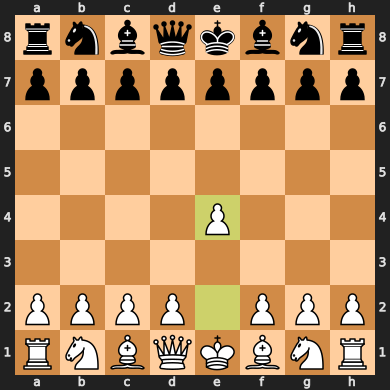

In [18]:
best_move, best_evaluation, ev = recursive_evaluation(engine, chess.Board())

In [19]:
engine

<SimpleEngine (pid=23336)>

In [ ]:
import queue

def build_optimal_move_tree(engine, opening_tree, initial_board, threshold=0.01):
    q = queue.PriorityQueue()
    q.put((-1, initial_board.fen(), opening_tree.root))  # Start with 100% probability

    while not q.empty():
        priority, current_fen, parent_node = q.get()
        probability = -priority  # Convert back to positive probability

        if probability < threshold:
            continue

        board = chess.Board(current_fen)
        best_move, evaluation = recursive_evaluation(engine, board)
        new_node = parent_node.add_child(best_move, board.fen(), evaluation)

        move_candidates = get_candidate_moves(current_fen)
        for move, move_prob in move_candidates.items():
            board.push_uci(move)
            new_priority = -probability * move_prob  # Multiply probabilities
            q.put((new_priority, board.fen(), new_node))
            board.pop()

# Usage
engine = ...  # Initialize LC0 engine
opening_tree = OpeningTree()
initial_board = chess.Board()
build_optimal_move_tree(engine, opening_tree, initial_board, threshold=0.01)


In [24]:
board = chess.Board()

In [28]:
board.push_uci('a1a1')

InvalidMoveError: invalid uci (use 0000 for null moves): 'a1a1'

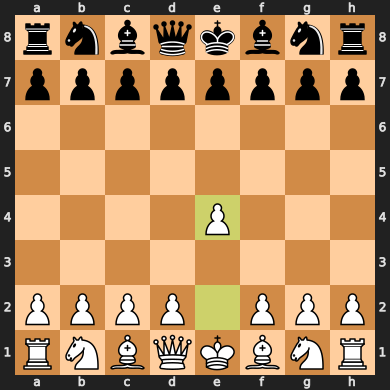

In [27]:
board